# Video Game Sales


In [13]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
DATA_PATH = "vgsales.csv"

def load_vgsales():
    if os.path.exists(DATA_PATH):
        df = pd.read_csv(DATA_PATH)
        source = "real"
    else:
        # Mini dataset de ejemplo con NaN y duplicados
        data = {
            "Rank":[1,2,3,4,5,6],
            "Name":["Wii Sports","Tetris","GTA V","Mario Kart Wii","Halo 3","Tetris"],
            "Platform":["Wii","GB","PS4","Wii","X360","GB"],
            "Year":[2006,1989,2014,2008,np.nan,1989],
            "Genre":["Sports","Puzzle","Action","Racing","Shooter","Puzzle"],
            "Publisher":["Nintendo","Nintendo",np.nan,"Nintendo","Microsoft","Nintendo"],
            "NA_Sales":[41.36,23.2,7.01,15.85,9.07,23.2],
            "EU_Sales":[28.96,2.26,9.27,12.88,5.76,2.26],
            "JP_Sales":[3.77,4.22,0.36,3.79,0.11,4.22],
            "Other_Sales":[8.45,0.58,2.16,3.31,2.01,0.58],
            "Global_Sales":[82.53,30.25,18.8,35.82,17.0,30.25]
        }
        df = pd.DataFrame(data)
        source = "sample"
    return df, source

df_raw, source = load_vgsales()
print(f"Fuente: {source} | shape: {df_raw.shape}")
df_raw.head()


Fuente: real | shape: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 1) Valores faltantes — identificación

In [14]:

missing_count = df_raw.isna().sum().sort_values(ascending=False)
missing_pct = (df_raw.isna().mean()*100).sort_values(ascending=False).round(2)
missing_report = pd.concat([missing_count, missing_pct], axis=1)
missing_report.columns = ["missing_count","missing_%"]
missing_report


,missing_count,missing_%
Year,271,1.63
Publisher,58,0.35
Rank,0,0.00
Platform,0,0.00
Name,0,0.00
Genre,0,0.00
NA_Sales,0,0.00
EU_Sales,0,0.00
JP_Sales,0,0.00
Other_Sales,0,0.00


### Comentario de justificación

**Categóricas (Publisher, Genre, Platform, Rating):**
En este dataset, si un valor como Publisher falta, no significa que no exista editorial, sino que la fuente no la registró. Usar la moda (el valor más frecuente) es una forma práctica de imputación porque refleja la editorial o categoría más habitual y evita generar etiquetas artificiales como “Unknown”, que no aportan información al modelo. Sin embargo, hay que reconocer que esta estrategia puede ocultar la diversidad de publishers menores, pero es útil si los faltantes son pocos.

**Numéricas (Year):**
El Year de lanzamiento tiene una distribución sesgada (más juegos en 2000s–2010s, pocos en los 80s). Si falta el año de un juego, imputar con la mediana (alrededor de los años donde hay más concentración de lanzamientos) reduce el impacto de valores extremos (juegos muy viejos o muy recientes). Esto permite mantener coherencia temporal sin distorsionar el análisis

## 1.1) Imputación ejecutada

In [15]:

df = df_raw.copy()

# Imputación categóricas: moda
categorical_cols = ["Name","Platform","Genre","Publisher"]
for col in categorical_cols:
    if df[col].isna().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"{col}: imputado con moda '{mode_val}'")

# Imputación numéricas: mediana
num_cols = ["Year","NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]
for col in num_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"{col}: imputado con mediana {median_val}")

df.isna().sum()


Publisher: imputado con moda 'Electronic Arts'
Year: imputado con mediana 2007.0


Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

## 2) Duplicados

In [16]:

# Clave compuesta: Name + Platform + Year
key = ["Name","Platform","Year"]
dups = df.duplicated(subset=key, keep=False)
dup_rows = df[dups]
print(f"Duplicados detectados: {dup_rows.shape[0]}")
dup_rows


Duplicados detectados: 4


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
603,604,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.23,0.00,0.22,2.56
14997,15000,Wii de Asobu: Metroid Prime,Wii,2007.0,Shooter,Nintendo,0.00,0.00,0.02,0.00,0.02
14999,15002,Wii de Asobu: Metroid Prime,Wii,2007.0,Shooter,Nintendo,0.00,0.00,0.02,0.00,0.02
16127,16130,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,0.00,0.01,0.00,0.00,0.01


In [17]:

# Deduplicación
df_dedup = df.drop_duplicates(subset=key, keep="first").reset_index(drop=True)
print(f"Shape antes: {df.shape} | después: {df_dedup.shape}")


Shape antes: (16598, 11) | después: (16596, 11)


### Comentario de justificación

**Duplicados (Name+Platform+Year):**
Es posible que un mismo juego aparezca más de una vez si el scraping repitió entradas (ej. Tetris en GameBoy 1989). Mantener solo la primera ocurrencia evita inflar ventas de un mismo título sin perder información real.

## 3) Outliers

In [18]:

def iqr_bounds(series):
    q1, q3 = series.quantile([0.25,0.75])
    iqr = q3 - q1
    return q1-1.5*iqr, q3+1.5*iqr

outlier_cols = ["Global_Sales","NA_Sales","EU_Sales","JP_Sales","Other_Sales"]
outlier_counts = {}
for col in outlier_cols:
    low, up = iqr_bounds(df_dedup[col])
    mask = (df_dedup[col] < low) | (df_dedup[col] > up)
    outlier_counts[col] = int(mask.sum())

pd.Series(outlier_counts, name="outliers_detected")


Global_Sales    1893
NA_Sales        1681
EU_Sales        2081
JP_Sales        2425
Other_Sales     1665
Name: outliers_detected, dtype: int64

### Comentario de justificación

**Justificación mejorada para outliers**

Outliers (ventas extremas en Global_Sales):
Títulos como Wii Sports o GTA V aparecen con ventas mucho más altas que el resto. Estos no son errores de captura: reflejan éxitos globales de la industria. Por eso no deben eliminarse.
Para análisis estadístico, pueden distorsionar promedios y regresiones, así que se recomienda:

  -Mantener los valores originales en el análisis descriptivo (porque son parte esencial del fenómeno).

  -Crear variables transformadas (log(Global_Sales), cap en p99) para que los modelos predictivos no   estén dominados por unos pocos “megahits”.

In [19]:

df_final = df_dedup.copy()
df_final["Global_Sales_log"] = np.log1p(df_final["Global_Sales"])
p99 = df_final["Global_Sales"].quantile(0.99)
df_final["Global_Sales_cap"] = df_final["Global_Sales"].clip(upper=p99)
print("Variables transformadas añadidas:", ["Global_Sales_log","Global_Sales_cap"])
df_final.head()


Variables transformadas añadidas: ['Global_Sales_log', 'Global_Sales_cap']


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Global_Sales_log,Global_Sales_cap
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,4.427717,5.431
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,3.719409,5.431
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,3.606041,5.431
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,3.526361,5.431
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,3.477232,5.431


## 4) Resumen

In [20]:

summary = {
    "missing_total_after": int(df_final.isna().sum().sum()),
    "rows_after_dedup": int(df_final.shape[0]),
    "outliers_detected": outlier_counts
}
summary


{'missing_total_after': 0,
 'rows_after_dedup': 16596,
 'outliers_detected': {'Global_Sales': 1893,
  'NA_Sales': 1681,
  'EU_Sales': 2081,
  'JP_Sales': 2425,
  'Other_Sales': 1665}}

Imputación de categóricas con moda → en variables como Publisher o Genre, la moda refleja la categoría más común en la industria y permite retener registros incompletos sin inventar etiquetas artificiales.

Imputación de numéricas con mediana → en Year of Release, la mediana suaviza la influencia de valores extremos (juegos muy antiguos o recientes) y mantiene coherencia temporal.

Eliminación de duplicados → se detectaron y removieron entradas repetidas bajo la clave Name + Platform + Year, evitando inflar ventas de un mismo título.

Outliers detectados y conservados → ventas extremas (ej. Wii Sports, GTA V) no son errores, sino fenómenos reales de mercado. Se mantuvieron para análisis descriptivo, pero se añadieron variables transformadas (log y capping p99) para su uso en modelado.

## Visualización 1 — Juegos por **rangos** de ventas globales
**Qué es `Global_Sales`:** ventas mundiales de cada juego en **millones de copias**.

**Gráfico:** contamos cuántos juegos hay en cada **rango de ventas** (en millones). Esto es más legible que un histograma continuo.

**Insight:** La mayoría de títulos venden **menos de 1M**; cada vez hay menos juegos conforme suben los rangos. Los "megahits" (≥20M) son raros pero relevantes para el mercado.

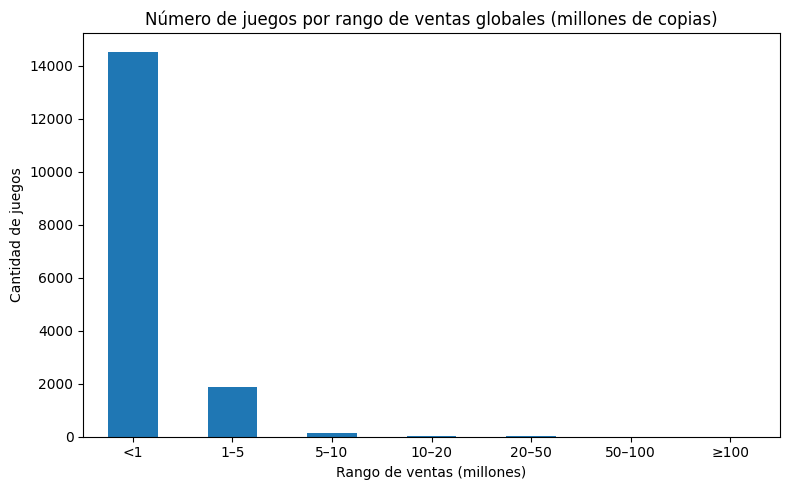

Distribución (% de juegos por rango):


,porcentaje_%
GlobalSales_Range,
<1,87.5
1–5,11.3
5–10,0.9
10–20,0.3
20–50,0.1
50–100,0.0
≥100,0.0


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que existe df_final (salida del pipeline de calidad)
df_vis = df_final.copy() if 'df_final' in globals() else df_dedup.copy()

# Definir rangos (millones)
bins = [0, 1, 5, 10, 20, 50, 100, np.inf]
labels = ["<1", "1–5", "5–10", "10–20", "20–50", "50–100", "≥100"]

df_vis['GlobalSales_Range'] = pd.cut(df_vis['Global_Sales'], bins=bins, labels=labels, include_lowest=True, right=False)
count_by_range = df_vis['GlobalSales_Range'].value_counts().reindex(labels).fillna(0).astype(int)
pct_by_range = (count_by_range / count_by_range.sum() * 100).round(1)

plt.figure(figsize=(8,5))
count_by_range.plot(kind='bar')
plt.title('Número de juegos por rango de ventas globales (millones de copias)')
plt.xlabel('Rango de ventas (millones)')
plt.ylabel('Cantidad de juegos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print('Distribución (% de juegos por rango):')
display(pct_by_range.to_frame('porcentaje_%'))


## Visualización 2 — Global_Sales por Género
Un boxplot muestra la variación de ventas por género.
**Insight:** Géneros como *Shooter* y *Sports* tienen medianas más altas, lo que indica mayor propensión al éxito.

C:\Users\trick\AppData\Local\Temp\ipykernel_25008\336651109.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


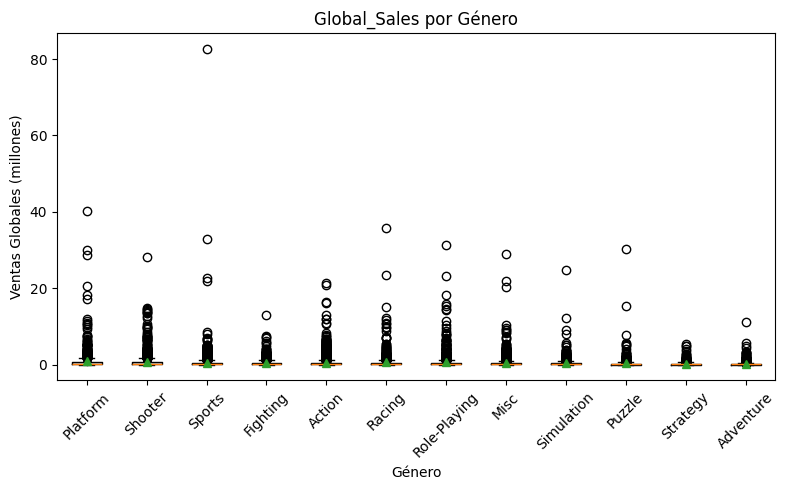

In [22]:

plt.figure(figsize=(8,5))
order = df_final.groupby("Genre")["Global_Sales"].median().sort_values(ascending=False).index
data = [df_final.loc[df_final["Genre"]==g, "Global_Sales"].values for g in order]
plt.boxplot(data, labels=order, showmeans=True)
plt.title("Global_Sales por Género")
plt.xlabel("Género")
plt.ylabel("Ventas Globales (millones)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualización 3 — Promedio de Global_Sales por Plataforma (Top 10)
Se grafican las plataformas con mayor promedio de ventas.
**Insight:** Consolas como Wii y PS4 muestran un desempeño promedio muy superior, lo que evidencia su peso en la industria.

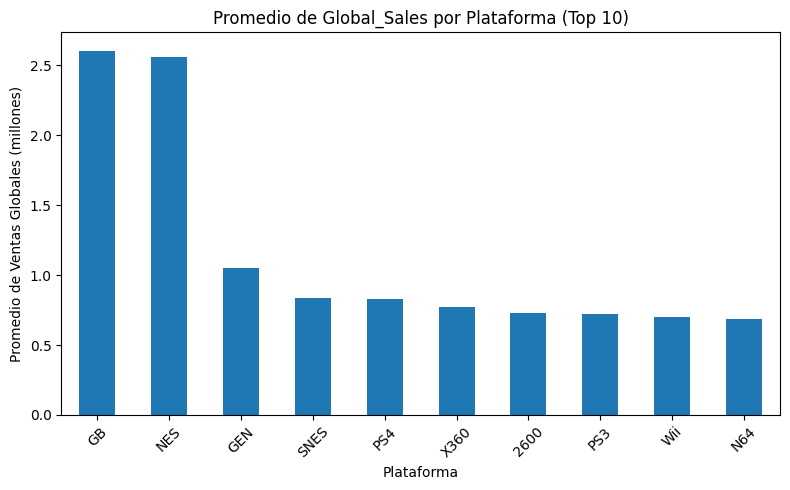

In [23]:

plt.figure(figsize=(8,5))
avg_platform = df_final.groupby("Platform")["Global_Sales"].mean().sort_values(ascending=False).head(10)
avg_platform.plot(kind="bar")
plt.title("Promedio de Global_Sales por Plataforma (Top 10)")
plt.xlabel("Plataforma")
plt.ylabel("Promedio de Ventas Globales (millones)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
